In [25]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import streamlit as st
import matplotlib.pyplot as plt
import os 


%matplotlib inline


In [ ]:
data_path = os.path.join(os.getcwd(), 'data')
rank_file = "2022-01-08.csv" 
dataset = pd.read_csv(f'{data_path}/{rank_file}')
    
dataset.head(10)


,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,428,13,Catan,1995,429,7.14,6.970,108024,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,103,36218,Dominion,2008,104,7.61,7.499,81561,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...
5,191,9209,Ticket to Ride,2004,192,7.41,7.305,76171,/boardgame/9209/ticket-ride,https://cf.geekdo-images.com/ZWJg0dCdrWHxVnc0e...
6,100,178900,Codenames,2015,101,7.60,7.508,74419,/boardgame/178900/codenames,https://cf.geekdo-images.com/F_KDEu0GjdClml8N7...
7,3,167791,Terraforming Mars,2016,4,8.42,8.274,74216,/boardgame/167791/terraforming-mars,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...
8,15,173346,7 Wonders Duel,2015,16,8.11,7.984,69472,/boardgame/173346/7-wonders-duel,https://cf.geekdo-images.com/WzNs1mA_o22ZWTR8f...
9,35,31260,Agricola,2007,36,7.93,7.809,66093,/boardgame/31260/agricola,https://cf.geekdo-images.com/dDDo2Hexl80ucK1Il...


In [ ]:
clean_data  = dataset.drop(["URL", "Thumbnail", "Unnamed: 0"], axis = 1) 
clean_data = clean_data.rename(columns = {"Bayes average": "Bayes Average", "Users rated" : "Number_of_Ratings"})

# Cleaned the data: took out the Bayes average, URL and thumbnail columns

clean_data.head(10)

In [30]:
file_reviews = "bgg-19m-reviews.csv" # second dataset
dataset_reviews = pd.read_csv(f'{data_path}/{file_reviews}')
dataset_reviews.head(10)
# takes 45 secs to run, tough

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
6,6,katrinacarenne,10.0,NaN,30549,Pandemic
7,7,DSpangler,10.0,NaN,30549,Pandemic
8,8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic
9,9,calbearfan,10.0,"Fun, fun game. Strategy is required, but defin...",30549,Pandemic


In [ ]:
# Clean the second dataset
# The unnamed section is kind of useless, and so are the user names
# the comments could be useful but 
clean_review_data = dataset_reviews.drop(["Unnamed: 0", "comment"], axis = 1)
clean_review_data = clean_review_data.rename(columns = {"user":"User", "rating":"Rating", "name" : "Name_of_Game"})
clean_review_data.head(10)
# trials on loc, loc is a label based index.
clean_review_data.loc[(clean_review_data["ID"] == 1752) & (clean_review_data['Rating'] >= 6.0)]

In [ ]:
# All the functions pre-Wilson Score:
# Finding the number of positive reviews per game:

def count_positive_reviews_per_game(dataset, ID):
    
    df_positive_reviews = dataset.loc[(dataset["ID"] == ID) & (dataset['Rating'] >= 6.0)] 
    # Loc Accesses a group of columns by labels and makes a new df
    positive_reviews_count = df_positive_reviews['Rating'].count() 
    # the variable counts every element in the df, so all the positive reviews
    
    return int(positive_reviews_count)
count_positive_reviews_per_game(clean_review_data, 30549 )

# Function to get the total number of ratings for any game out of any dataset.
def total_reviews(dataset, ID):
    # Identify the column with the total number of ratings for every game (yields a series)
    total_reviews = dataset['Number_of_Ratings']
    # get specific row of the first ID, I might not even need this line...
    total_reviews_ID = total_reviews.loc[(dataset['ID']== ID)]
    return int(total_reviews_ID.iloc[0])

total_reviews(clean_data, 30549)

def share_of_positive_reviews_per_game(ID):
    share_of_pos_reviews_per_game = float(count_positive_reviews_per_game(clean_review_data, ID) / total_reviews(clean_data, ID))
    return round(share_of_pos_reviews_per_game, 3)

share_of_positive_reviews_per_game(30549)

# trial run for share of positive reviews for each game
# for id in clean_data['ID']:
#     print(share_of_positive_reviews_per_game(id))

108975

In [12]:
def confidence_level(confidence):
    cl = norm.ppf(1- (1 - confidence)/2)
    return cl
# https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa

def Wilson_Function(ID, confidence = .95):
    z = confidence_level(confidence)
    n = total_reviews(clean_data, ID)
    p_hat = 1 * share_of_positive_reviews_per_game(ID) #/ total_reviews(clean_data, ID)
    
    wilson_score = round(float((p_hat + z**2/(2*n) - z*np.sqrt((p_hat*(1 - p_hat) + z**2/(4*n))/n)) / (1 + (z**2)/n)), 2)
    


    return wilson_score
Wilson_Function(30549 , .95)

0.94

In [ ]:
# Bayesian Functions 
def array_scores(dataset, ID):
    list_scores = []
    for i in range(1,11):
        # return rows for my specific ID with the rating being between certain values.
        number_reviews_for_each_rating = dataset.loc[(dataset['ID'] == ID) & (dataset['Rating'].between(i, i + 1, inclusive='left'))]
        i_reviews = number_reviews_for_each_rating['Rating'].count()
        
        
        list_scores.append(int(i_reviews))
    
    
    return list_scores
array_scores(clean_review_data, 1752)

def Bayesian_Average(ID, dataset = clean_review_data, confidence = .95):
    z = confidence_level(confidence)
    n = array_scores(dataset, ID)
    N = sum(n)
    first_part = 0
    second_part = 0
    for k, n_k in enumerate(n):
        first_part += (k+1)*(n[k]+1)/(N + 10)
        second_part += (k+1)*(k+1)*(n[k]+1)/(N+10)
    score = first_part - z*np.sqrt((second_part - first_part*first_part)/(N+11))
    
    return round(float(score), 2)

Bayesian_Average(1752)
# I need a better understanding of wtf this does. =
# morning kind of job.



[2, 2, 1, 6, 9, 5, 4, 1, 0, 0]

In [15]:
# New_Column, function, useless now.
def New_Column(dataset, function):
    # create an empty list (our future column)
    New_column = []
    # for each row in a dataset I have to find its ID and apply a the funciton over it
    for id in dataset['ID'].unique():
        New_column.append(function(id))
    
    return New_column



In [16]:
# Adding a column to a dataset
def add_new_column_to_dataset(dataset_input, dataset_output, function, title_of_column = 'New Column'):
    # create an empty list (our future column)
    New_column = []
    # for each row in a dataset I have to find its ID and apply a the funciton over it
    for id in dataset_input['ID'].unique():
        New_column.append(function(id))
        
    dataset_output.insert(0, title_of_column, New_column)
    
    return dataset_output

# A function to create a database for each section of my data (most, mid, and leaset reviewed)
def clean_review_data_x_reviewed(output_database, global_database = clean_review_data):
    desired_ids = output_database['ID']
    clean_review_data_x_reviewed = global_database[global_database['ID'].isin(desired_ids)]
    return clean_review_data_x_reviewed

In [17]:
most_reviewed_games = clean_data[clean_data['Number_of_Ratings'] > 25000] # Top 100 games, this way. (65000 for top 11)
add_new_column_to_dataset(clean_review_data_x_reviewed(most_reviewed_games),  most_reviewed_games, Bayesian_Average, 'New_Bayesian_Average') 
most_reviewed_games.sort_values('New_Bayesian_Average', ascending = False)

,New_Bayesian_Average,ID,Name,Year,Rank,Average,Bayes Average,Number_of_Ratings
26,8.66,174430,Gloomhaven,2017,1,8.74,8.511,47827
98,8.55,224517,Brass: Birmingham,2018,3,8.66,8.418,25484
28,8.50,161936,Pandemic Legacy: Season 1,2015,2,8.59,8.442,45041
97,8.33,187645,Star Wars: Rebellion,2016,8,8.42,8.172,25586
7,8.32,167791,Terraforming Mars,2016,4,8.42,8.274,74216
...,...,...,...,...,...,...,...,...
83,6.42,3955,BANG!,2002,1337,6.51,6.359,27824
80,6.20,320,Scrabble,1948,1916,6.27,6.159,28245
30,5.82,1927,Munchkin,2001,4796,5.89,5.717,43750
59,5.52,181,Risk,1959,20905,5.59,5.462,31717


In [18]:
# LEAST Reviewed Games
least_reviewed_games = clean_data[clean_data['Number_of_Ratings']== 50] # Bottom 164 games, possibly change this interval, overall pretty goo job though.

add_new_column_to_dataset(clean_review_data_x_reviewed(least_reviewed_games), least_reviewed_games, Bayesian_Average, 'New_Bayesian_Average')

least_reviewed_games.sort_values('New_Bayesian_Average', ascending = False)
# you could look at this top ten and break down the comments for the top 10, now that's actually kind of cool.
# can organize them by year

,New_Bayesian_Average,ID,Name,Year,Rank,Average,Bayes Average,Number_of_Ratings
17225,7.70,261265,Monster-Bande,2018,11865,7.06,5.537,50
17235,7.66,21095,Mage Master,2005,20591,4.80,5.471,50
17188,7.38,6124,Waterloo: The Last Great Battle,1981,16057,6.22,5.512,50
17147,7.33,284617,King Thief Minister,2019,12487,7.46,5.533,50
17184,7.24,246895,DC Comics Dice Masters: Justice Campaign Box,2019,9300,7.92,5.564,50
...,...,...,...,...,...,...,...,...
17218,3.59,342638,BIOTOPIA,2021,11524,7.68,5.540,50
17223,3.49,6735,Star Explorer,1982,12368,6.84,5.534,50
17256,3.46,7586,An Enchanting Evening,1981,18262,5.49,5.498,50
17285,3.25,150615,Fanhunter: Las Montañas de la Locura – Electri...,2013,18292,5.67,5.498,50


In [19]:
# MID Reviewed Games
mid_reviewed_games = clean_data[clean_data['Number_of_Ratings'].between(3500, 4000)] #65000 for top 11.
#len(clean_data2)

add_new_column_to_dataset(clean_review_data_x_reviewed(mid_reviewed_games), mid_reviewed_games, Bayesian_Average, 'New_Bayesian_Average')
mid_reviewed_games.sort_values('New_Bayesian_Average', ascending = False)

,New_Bayesian_Average,ID,Name,Year,Rank,Average,Bayes Average,Number_of_Ratings
985,8.50,243,Advanced Squad Leader,1985,352,8.00,7.065,3588
984,7.88,204836,Escape Room: The Game,2016,1041,7.02,6.522,3590
896,7.85,155873,Power Grid Deluxe: Europe/North America,2014,233,7.99,7.233,3972
988,7.83,205597,Jump Drive,2017,1026,7.03,6.530,3575
971,7.77,297030,Tekhenu: Obelisk of the Sun,2020,338,7.87,7.079,3654
...,...,...,...,...,...,...,...,...
898,6.01,60,Vinci,1999,915,7.08,6.589,3970
909,5.88,1339,Dungeon!,1975,4238,5.99,5.762,3929
941,5.74,39339,Android,2008,1408,6.74,6.330,3781
946,5.38,227224,The Red Cathedral,2020,320,7.90,7.098,3769


In [20]:
# Motivation for range of mid_reviewed_games:

# 13.6k games between 30 reviews and 200 reviews
# 5.3k games between 200 reviews and a 1000 reviews
# 1.3 k games between 1000 and 2200 reviews
# the average being 866 and there being 130000 games with very few reviews I thought 3500-4000

average_ratings_per_game = clean_data['Number_of_Ratings']
average_ratings_dataset = int(np.average(average_ratings_per_game))
average_ratings_dataset

866

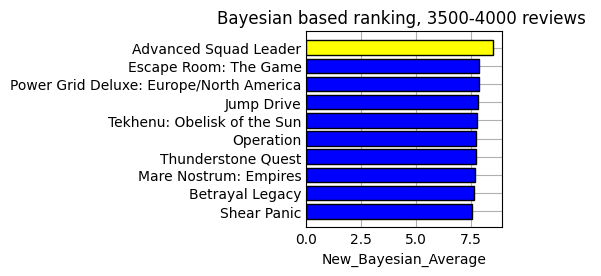

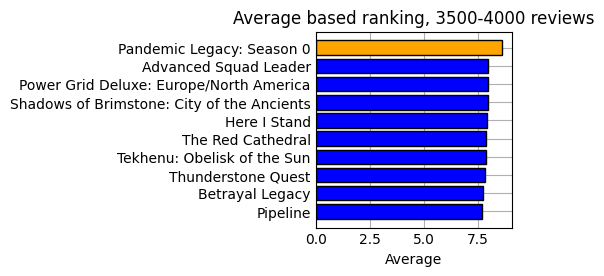

In [23]:
# Plotting the New_Bayesian_Average vs the common average for the top rated games
# How tf you use matplotlib lmao.
def horizontal_bar_graph(dataset, sortby_variable, graph_title, y_labels = 'Name',top_color = 'red' ):
    # data
    sorted_reviews = dataset.sort_values(sortby_variable, ascending = False)
    sorting_by_variable = sorted_reviews[sortby_variable].iloc[0:10]
    displayed_titles = sorted_reviews[y_labels].iloc[0:10]
    
    colors = [top_color,'blue','blue','blue','blue','blue','blue','blue','blue','blue' ]
    plt.style.use('_mpl-gallery')
    pos = np.arange(len(displayed_titles))
    
    # plot
    fig, ax = plt.subplots() 

    ax.barh(pos, sorting_by_variable, align = 'center', edgecolor = 'black', color = colors )
    ax.set_yticks(pos, labels = displayed_titles)
    ax.invert_yaxis()
    ax.set_xlabel(sortby_variable)
    ax.set_title(graph_title)
    
    return plt.show()
 


# Bar Graphs of Bayesian Average Ranking
#horizontal_bar_graph(most_reviewed_games, 'New_Bayesian_Average', 'Bayesian based ranking, 25k+ reviews')
horizontal_bar_graph(mid_reviewed_games, 'New_Bayesian_Average', 'Bayesian based ranking, 3500-4000 reviews ', top_color='yellow')
#horizontal_bar_graph(least_reviewed_games, 'New_Bayesian_Average', 'Bayesian based ranking, 50 reviews ', top_color='green')

# Bar Graphs of Average Ranking
#horizontal_bar_graph(most_reviewed_games, 'Average', 'Average based ranking, 25k+ reviews', top_color='violet')
horizontal_bar_graph(mid_reviewed_games, 'Average', 'Average based ranking, 3500-4000 reviews', top_color='orange')
#horizontal_bar_graph(least_reviewed_games, 'Average', 'Average based ranking, 50 reviews', top_color='pink')


In [ ]:
# The Wilson Score to do properly

# Correct Modularisation
# Classes

# Streamlit a tomorrow kind of job.

# Understand my own Bayesian Function (c'è l'articolo)
# I understood it, it's calculating a range and chooses the lower bound of the prior average times a weight + the old ratings divied by the number of items rated + the weight.
# more or less.

# understand my own code: sunday all day every day.

# Possibly implement more methods
# graph all the 100 games for greater differentiation
